# Training a Vision Transformer for Object Detection on the TACO Dataset
This notebook shows how to train a DeTr model on the TACO dataset using the `transformers` library. The TACO dataset is a dataset for detecting garbage in the wild. The dataset is available at [this link](http://tacodataset.org/). A subset of this dataset that has bounding boxes drawn around items is available on Roboflow at [this link](https://universe.roboflow.com/divya-lzcld/taco-mqclx/dataset/3). This subset is used in this notebook for training, testing, and evaluation. Special thanks to the authors of the TACO dataset for making this dataset available and to hugingface for their easy-to-use library and tutorial posted [here](https://huggingface.co/learn/computer-vision-course/en/unit3/vision-transformers/vision-transformer-for-objection-detection).


## Load the Data
First, we need to get our data from the Roboflow coco format into a usable format for the transformers library. We will use the `supervision` library to initially load the data and then custom functions to convert the data into a dictionary format that the `Dataset` class in the transformers library can use. Thanks to ChatGPT for assistance generating this code snippet.

In [1]:
from datasets import Dataset
from PIL import Image
import json
import os
import supervision as sv

filter out small objects from the dataset

Load in supervision datasets

In [2]:
ds_path = r"C:\Users\isaac\dev\CV_Garbage_Detection\Data_Cleaned"

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "train"),
    annotations_path=os.path.join(ds_path, "train", "_annotations.coco.json"),
)

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "test"),
    annotations_path=os.path.join(ds_path, "test", "_annotations.coco.json"),
)

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "valid"),
    annotations_path=os.path.join(ds_path, "valid", "_annotations.coco.json"),
)

helper functions to convert coco format to dict

In [3]:
def sv_to_custom_format(sv_dataset, class_mapping=None):    
    images, image_ids, widths, heights, objects = [], [], [], [], []  
    image_id = 0
    
    for path, _, detections in sv_dataset:
        # Load image
        img = Image.open(path)
        images.append(img)
        
        # Get image id
        image_ids.append(image_id)
        
        # Get image dimensions
        width, height = img.size
        widths.append(width)
        heights.append(height)
        
        
        # Extract object information
        object_ids, bboxes, areas, categories = [], [], [], []
        
        skip_img = False

        for detection in detections:
            x_min, y_min, x_max, y_max = detection[0]  # Supervision bounding box
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
            area = (x_max - x_min) * (y_max - y_min)  # Compute area
            if detection[3] not in class_mapping.keys(): # Skip classes not in class mapping (removed classes)
                skip_img = True
                continue
            else:
                skip_img = False
                
            category = class_mapping[detection[3]] if class_mapping else str(detection[3])
            object_ids.append(detection[3])

            bboxes.append(bbox)
            areas.append(area)
            categories.append(category)

        objects.append({
            "id": object_ids,
            "bbox": bboxes,
            "area": areas,
            "category": categories
        })
        if not skip_img:
            image_id += 1

    formatted_data = {
        "image": images,
        "image_id": image_ids,
        "width": widths,
        "height": heights,
        "objects": objects
    }
    return formatted_data

def get_class_mappings_from_coco(annotation_path):
    with open(annotation_path, "r") as f:
        coco_data = json.load(f)
    
    # Extract categories
    categories = coco_data["categories"]
    class_mapping = {category["id"]: category["name"] for category in categories}
    return class_mapping

In [4]:
class_mappings = get_class_mappings_from_coco(os.path.join(ds_path, "train", "_annotations.coco.json"))

label2id = {v: k for k, v in class_mappings.items()}
id2label = {k: v for k, v in class_mappings.items()}

formatted_train = sv_to_custom_format(ds_train, class_mappings)
formatted_test = sv_to_custom_format(ds_test, class_mappings)
formatted_valid = sv_to_custom_format(ds_valid, class_mappings)

Create Dataset objects from dicts

In [5]:
train_dataset = Dataset.from_dict(formatted_train)
test_dataset = Dataset.from_dict(formatted_test)
valid_dataset = Dataset.from_dict(formatted_valid)

## Explore the Data

Draw a bounding box to see what the data looks like

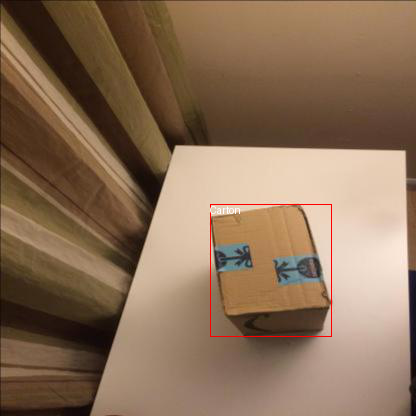

In [6]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


draw_image_from_idx(dataset=train_dataset, idx=1)

Plot a few images with bounding boxes

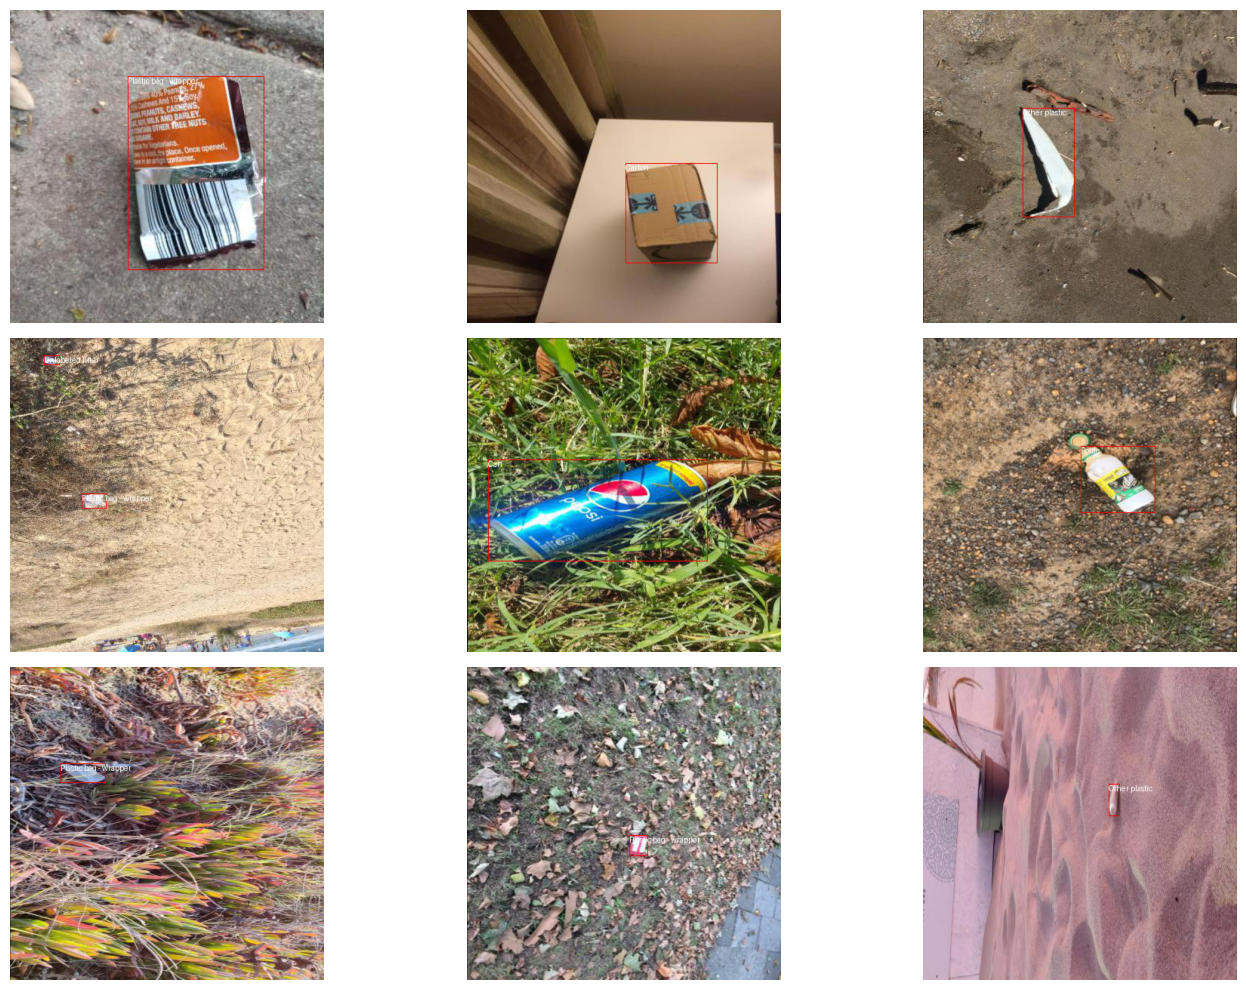

In [7]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(train_dataset, range(9))

## Train the Model

Start by creating a base DeTr model from a checkpoint and finetune on our dataset

In [8]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor, TrainingArguments, Trainer

In [9]:
checkpoint = "microsoft/conditional-detr-resnet-50"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([15]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([15, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Augment the dataset with a few transformations to improve generalization and prevent overfitting

In [10]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

Reformat annotations to match the model's expected format

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [12]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [13]:
train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

Create a collate function to pad the annotations, define the training arguments, and train the model

In [14]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [15]:
training_args = TrainingArguments(
    output_dir="conditional-detr-resnet-50-finetuned-v4",
    per_device_train_batch_size=8,
    num_train_epochs=200,
    fp16=True,
    save_steps=25000,
    logging_steps=500,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()

  0%|          | 0/150800 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'loss': 78.0808, 'grad_norm': 93.41703033447266, 'learning_rate': 9.967572944297083e-06, 'epoch': 0.66}
{'loss': 5.0351, 'grad_norm': 55.07204818725586, 'learning_rate': 9.934416445623342e-06, 'epoch': 1.33}
{'loss': 3.0234, 'grad_norm': 45.45083999633789, 'learning_rate': 9.901259946949603e-06, 'epoch': 1.99}
{'loss': 2.4713, 'grad_norm': 33.37253189086914, 'learning_rate': 9.868103448275863e-06, 'epoch': 2.65}
{'loss': 2.2123, 'grad_norm': 58.81147003173828, 'learning_rate': 9.834946949602124e-06, 'epoch': 3.32}
{'loss': 2.0377, 'grad_norm': 113.616943359375, 'learning_rate': 9.801790450928382e-06, 'epoch': 3.98}
{'loss': 1.9266, 'grad_norm': 69.09268951416016, 'learning_rate': 9.768633952254643e-06, 'epoch': 4.64}
{'loss': 1.8399, 'grad_norm': 74.38976287841797, 'learning_rate': 9.735477453580902e-06, 'epoch': 5.31}
{'loss': 1.7572, 'grad_norm': 28.93790054321289, 'learning_rate': 9.702320954907164e-06, 'epoch': 5.97}
{'loss': 1.7, 'grad_norm': 29.041786193847656, 'learning_rate': 

TrainOutput(global_step=150800, training_loss=0.7366757489515553, metrics={'train_runtime': 83167.22, 'train_samples_per_second': 14.506, 'train_steps_per_second': 1.813, 'total_flos': 6.020783313592317e+20, 'train_loss': 0.7366757489515553, 'epoch': 200.0})

Save the model both locally and on the Hugging Face model hub

In [17]:
trainer.save_model("conditional-detr-resnet-50-finetuned-v4")

In [18]:
model.push_to_hub("isaacberlin/conditional-detr-resnet-50-TACO-finetuned")

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/isaacberlin/conditional-detr-resnet-50-TACO-finetuned/commit/c78268e3998d0c6378d351b456a76a2dd52bed3b', commit_message='Upload ConditionalDetrForObjectDetection', commit_description='', oid='c78268e3998d0c6378d351b456a76a2dd52bed3b', pr_url=None, pr_revision=None, pr_num=None)

## Model Evaluation

In [19]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

Use the `pipeline` class to evaluate the model on individual images in the test set for qualitative evaluation

Predicted Results: [{'score': 0.7902438044548035, 'label': 'Cup', 'box': {'xmin': 136, 'ymin': 181, 'xmax': 186, 'ymax': 249}}]


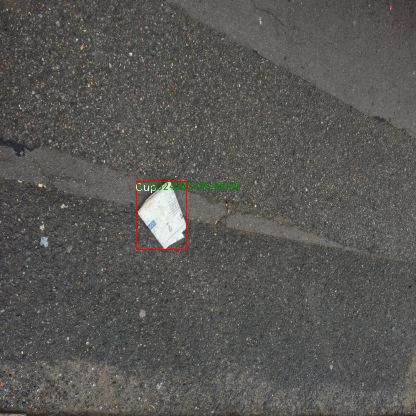

In [20]:
from transformers import pipeline

idx = 25

img = valid_dataset[idx]["image"]
obj = pipeline("object-detection", model="conditional-detr-resnet-50-finetuned-v4", device=0)

tr = 0.5

res = obj(img, threshold=tr)
print("Predicted Results:",res)
plot_results(img, res, threshold=tr)

Ground Truth: {'area': [3450.0], 'bbox': [[137.0, 181.0, 50.0, 69.0]], 'category': ['Cup'], 'id': [5]}


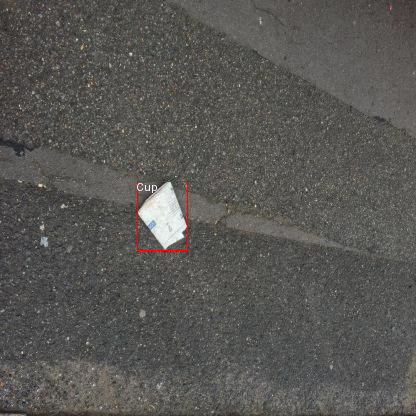

In [21]:
print("Ground Truth:", valid_dataset[idx]["objects"])
draw_image_from_idx(valid_dataset, idx)

Plot the loss curve to see how the model performed during training

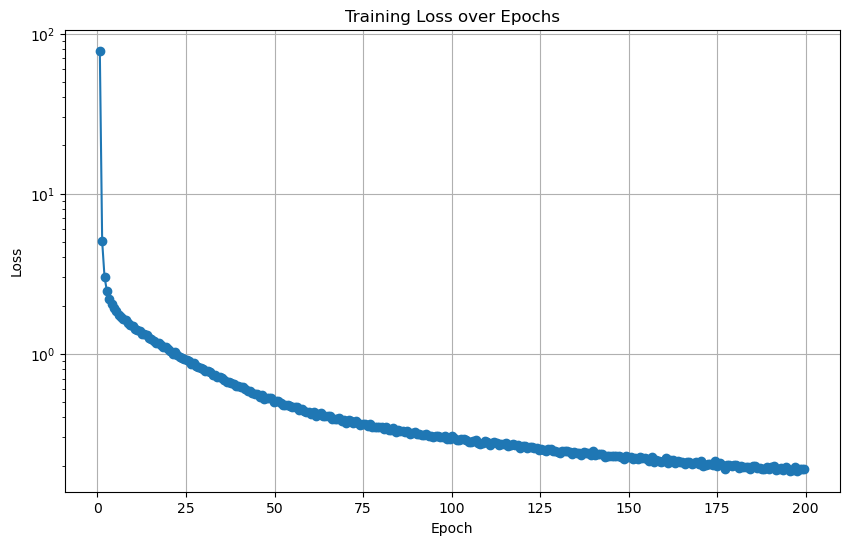

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract loss from log history
log_history = trainer.state.log_history

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(log_history)

# Filter only relevant columns
loss_df = df[["epoch", "loss"]].dropna()

# Group by epoch to compute average loss per epoch
avg_loss_per_epoch = loss_df.groupby("epoch")["loss"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_loss_per_epoch.index, avg_loss_per_epoch.values, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.yscale("log")
plt.show()

Calculate the average precision and mAP for the model

In [23]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os

In [24]:
import json

all_predictions = []

id = 0

for item in test_dataset:
    image = item["image"]  
    image_id = id       
    outputs = obj(image)
    for output in outputs:
        box = output["box"]
        x_min, y_min, x_max, y_max = box.values()
        all_predictions.append({
            "image_id": image_id,
            "category_id": label2id[output["label"]],
            "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
            "score": output["score"]
        })
    id += 1
        
with open("predictions.json", "w") as f:
    json.dump(all_predictions, f, indent=4)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [25]:
coco_gt = COCO(os.path.join(ds_path, "test", "_annotations.coco.json"))
coco_dt = coco_gt.loadRes("predictions.json")

coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [26]:
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [27]:
# Average Precision (AP) and Average Recall (AR)
ap = coco_eval.stats[0]  # AP@[IoU=0.50:0.95]
ar = coco_eval.stats[8]  # AR@[IoU=0.50:0.95]

print(f"Average Precision (AP): {ap:.4f}")
print(f"Average Recall (AR): {ar:.4f}")

Average Precision (AP): 0.2604
Average Recall (AR): 0.2992
